<a href="https://colab.research.google.com/github/HSCI805/peer_reviews/blob/main/4494.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4494

# 0) Set up

(installation should take less than 2 minutes)

In [ ]:
if ( !require('survey') )
{
  install.packages("survey")
  library(survey)
}

Loading required package: survey

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘survey’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘minqa’, ‘numDeriv’, ‘mitools’


Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart




In [ ]:
### import NHANES data using nhanesA
#library(nhanesA)
library(knitr)
library(dplyr)
#library(crosstable)
#library(readxl)
library(ggplot2)
#library(survey)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 1) Load preliminary data

In [ ]:
data_NHANES0 <- read.csv('https://raw.githubusercontent.com/HSCI805/peer_reviews/main/He2022/nhanes_before.csv')

In [ ]:
dim(data_NHANES0)

[1] 101316     18

In [ ]:
head(data_NHANES0, 3)

,X,UID,Gender,Age_y,Ethnicity,Ref_gend,Ref_age,Red_edu,Ref_marital,Povratio,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,BMI,Cotinine,Asthma,Smoke_home
,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>
1,1,1,Female,2,Non-Hispanic Black,Female,27,High School Grad/GED or equivale,Never married,0.86,9727.079,10982.90,1,5,14.90,NA,No,No
2,2,2,Male,77,Non-Hispanic White,Male,77,College Graduate or above,NA,5.00,26678.636,28325.38,3,1,24.90,0.035,No,No
3,3,3,Female,10,Non-Hispanic White,Male,37,Some College or AA degree,Married,1.47,43621.681,46192.26,2,7,17.63,0.060,No,Yes


In [ ]:
unique(data_NHANES0$Cotinine)[1:10]

[1]      NA   0.035   0.060   1.810   0.071   0.090   2.620 374.580   0.130
[10]   0.340

# 2) Define study population 

In [ ]:
######## ELIGIBILITY CRITERIA #############
## Aged 3 to 12 years old, 
## with cotinine levels 
## with BMI data
## with asthma data

data_NHANES1 <- data_NHANES0 %>%
  mutate(eligible = case_when(
    Age_y %in% 3:12 & ## when age is between 3 and 12 AND
      (!is.na(Cotinine)) & ## Cotinine is not NA AND
      (!is.na(BMI)) & ## BMI is not NA AND
      (!is.na(Asthma)) ## asthma is not NA, then make 1
      ~ 1, 
    TRUE ~ 0))

## Aside from LT: below will give equivalent result

In [ ]:
indx <-(  !is.na(data_NHANES0$Cotinine) &
          !is.na(data_NHANES0$Asthma) & 
          !is.na(data_NHANES0$BMI) & 
            (data_NHANES0$Age_y >2 ) & (data_NHANES0$Age_y < 13 ) )

dim( data_NHANES0[ indx, ] )

[1] 13302    18

In [ ]:
##subset data to only participants with eligible == 1

data_NHANES2<-filter(data_NHANES1, eligible == 1)

dim(data_NHANES2)

[1] 13302    19

In [ ]:
13302-14954

[1] -1652

In [ ]:
## additional exclusion criteria
## DEMOGRAPHIC VARIABLES THAT FURTHER EXCLUSION
## FAMILY PIR MISSING
## GENDER OF REF MISSING
## EDUCATION OF REF MISSING
## MARTIAL STATUS OF REF MISSING

### calculate the number of individuals from each group that do not meet criteria

paste0('Omitted due to NA in POV ratio: ', sum(is.na(data_NHANES2$Povratio)))
paste0('Omitted due to NA in ref gender: ', sum(is.na(data_NHANES2$Ref_gend)))
paste0('Omitted due to NA in ref education level: ', sum(is.na(data_NHANES2$Red_edu)) )
paste0('Omitted due to NA in ref marital status: ', sum(is.na(data_NHANES2$Ref_marital)) )
941+4+401+521
13302-1867

data_NHANES3 <-filter(data_NHANES2, (!is.na(Povratio)) & ## poverty ratio is not NA
                      (!is.na(Ref_gend)) & # reference gender is not NA
                      (!is.na(Red_edu)) & # reference education is not NA
                      (!is.na(Ref_marital)) ) # reference martial status is not NA

[1] "Omitted due to NA in POV ratio: 941"

[1] "Omitted due to NA in ref gender: 4"

[1] "Omitted due to NA in ref education level: 401"

[1] "Omitted due to NA in ref marital status: 521"

[1] 1867

[1] 11435

# 3) Determine cut-off 

"In this analysis, we used a serum cotinine 
cutof of 0.0436 ng/mL (median) to defne serum cotinine 
levels, with<0.0436  ng/mL as low-level serum cotinine 
and≥0.0436 ng/mL as high-level serum cotinine" He et al. 2022


In [ ]:
### recategorize variables for Cotinine and BMI
##cotinine-- above and below median value

median(data_NHANES3$Cotinine) ## MEdian is 0.047

[1] 0.047

In [ ]:
data_NHANES4<- data_NHANES3%>%
  mutate(Cotinine_group = case_when(
    Cotinine < 0.047 ~ "low",
    Cotinine >= 0.047 ~ "high",
  ))

#Change to factor
data_NHANES4$Cotinine_group<-as.factor(data_NHANES4$Cotinine_group)

## BMI
### calculate z-score then categorize
data_NHANES4$BMI_z <- (data_NHANES4$BMI-mean(data_NHANES4$BMI))/sd(data_NHANES4$BMI)

# 4) Check on BMI

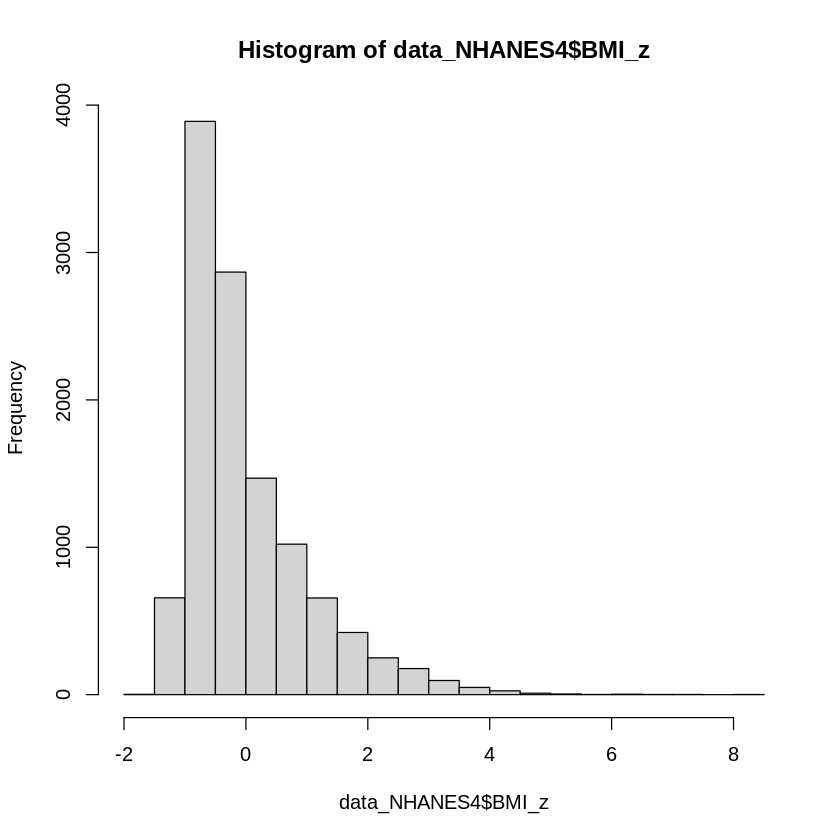

In [ ]:
hist(data_NHANES4$BMI_z)

"The sex-specifc BMI (body mass index)-for-age reference of Centers for Disease Control and Prevention 
(CDC) and LMS method were used to calculate the BMI 
z-score [15]. Subjects were categorized based on BMI 
percentiles as follows: Group A [underweight and normal 
weight (<85th percentile)], Group B [overweight (≥85th 
percentile to<95th percentile)], and Group C [obesity 
(≥95th percentile)] [15], which was consistent with other 
epidemiological studies [14, 16]." He et al. 2022

In [ ]:
## find 85th and 95th percentile

(bmi_cut_offs <-quantile(data_NHANES4$BMI_z, probs = c(.85, .95)))

85%       95% 
0.9905988 2.0692652

In [ ]:
## create BMI groups:
## Group A: under/normal weight- (<85th percentile)
## Group B: overweight (≥ 85th percentile to < 95th percentile)
## Group c: obesity (≥ 95th percentile)

## Use casewhen to create BMI category
data_NHANES4<- data_NHANES4%>%
  mutate(BMI_group = case_when(
    BMI_z < 0.9905988 ~ "under/normal weight", 
    BMI_z %in% 0.9905988:2.0692652~ "overweight",
    BMI_z >= 2.0692652 ~ "obese",
    TRUE~ "overweight"
  ))
table(data_NHANES4$BMI_group)


              obese          overweight under/normal weight 
                579                1167                9858 

## Aside from LT: below avoids manual specification of constants via variable


In [ ]:
data_NHANES4b <- data_NHANES4 %>%
  mutate(BMI_group = case_when(
    BMI_z < bmi_cut_offs[1] ~ "under/normal weight", 
    BMI_z %in% bmi_cut_offs[1]:bmi_cut_offs[2] ~ "overweight",
    BMI_z >= bmi_cut_offs[1]  ~ "obese",
    TRUE~ "overweight"
  ))

In [ ]:
# check
dim(data_NHANES4) 
dim(data_NHANES4b) 

[1] 11604    22

[1] 11604    22

# 5) Prepare other variables

In [ ]:
### Recategorize messy variables

## smoked in home
data_NHANES5<- data_NHANES4%>%
  mutate(Smoke_home_group = case_when(
    Smoke_home == "No" |
    Smoke_home == "No one in houseold is a smoker" ~ "No",
    Smoke_home == "1 household member is a smoker" |
    Smoke_home == "2 household members are smokers" |
    Smoke_home == "3 or more household members are" |
    Smoke_home == "Yes" ~ "Yes",
  ))

In [ ]:
##Martial status
data_NHANES6<- data_NHANES5 %>%
  mutate(Ref_marital_group = case_when(
    Ref_marital == "Divorced" ~ "Divorced",
    Ref_marital == "Living with partner" ~ "Living with partner",
    Ref_marital == "Married" |
    Ref_marital == "Married/Living with partner"~ "Married",
    Ref_marital == "Never married" |
    Ref_marital == "Never Married" ~ "Never married",
    Ref_marital == "Widowed/Divorced/Separated"|
    Ref_marital == "Widowed" ~ "Widowed",
    Ref_marital == "Separated" ~ "Separated",
  ))

typeof(data_NHANES6$Ref_marital_group)

[1] "character"

In [ ]:
data_NHANES7<- data_NHANES6%>%
  mutate(Ref_edu_group = case_when(
    Red_edu == "Less Than 9th Grade" ~ "Less Than 9th Grade",
    Red_edu == "Less than high school degree" |
    Red_edu == "9-11th Grade (Includes 12th grad"~ "9-11th Grade",
    Red_edu == "College graduate or above" |
    Red_edu == "College Graduate or above" ~ "College graduate or higher",
    Red_edu == "High school grad/GED or some col" |
    Red_edu == "High School Grad/GED or equivale" |
    Red_edu == "High School Grad/GED or Equivale" ~ "High school graduate",
    Red_edu == "Some College or AA degree" ~ "Some College or AA degree"
  ))

data_NHANES7$Ref_age<-as.numeric(data_NHANES7$Ref_age)

dim(data_NHANES7)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


[1] 11604    25

In [ ]:
#Reclassify to 0 and 1 for each variables
data_NHANES8<- data_NHANES7%>%
  mutate(Cotinine_num = case_when(
    Cotinine_group == "low"~ 0,
    Cotinine_group == "high"~ 1,
  ))

data_NHANES9<- data_NHANES8%>%
  mutate(BMI_num = case_when(
    BMI_group == "under/normal weight"~ 0,
    BMI_group == "overweight" ~ 1,
    BMI_group == "obese" ~ 2,
  ))

data_NHANES<- data_NHANES9%>%
  mutate(Asthma_bin = case_when(
    Asthma == "Don't know" |
      Asthma == "No" ~ 0,
    Asthma == "Yes" ~ 1,
  ))

In [ ]:
# make sure variable are factors
data_NHANES$Asthma_bin<-as.factor(data_NHANES$Asthma_bin)
data_NHANES$BMI_num<-as.factor(data_NHANES$BMI_num)
data_NHANES$Cotinine_num<-as.factor(data_NHANES$Cotinine_num)

# 6) Examine the weights

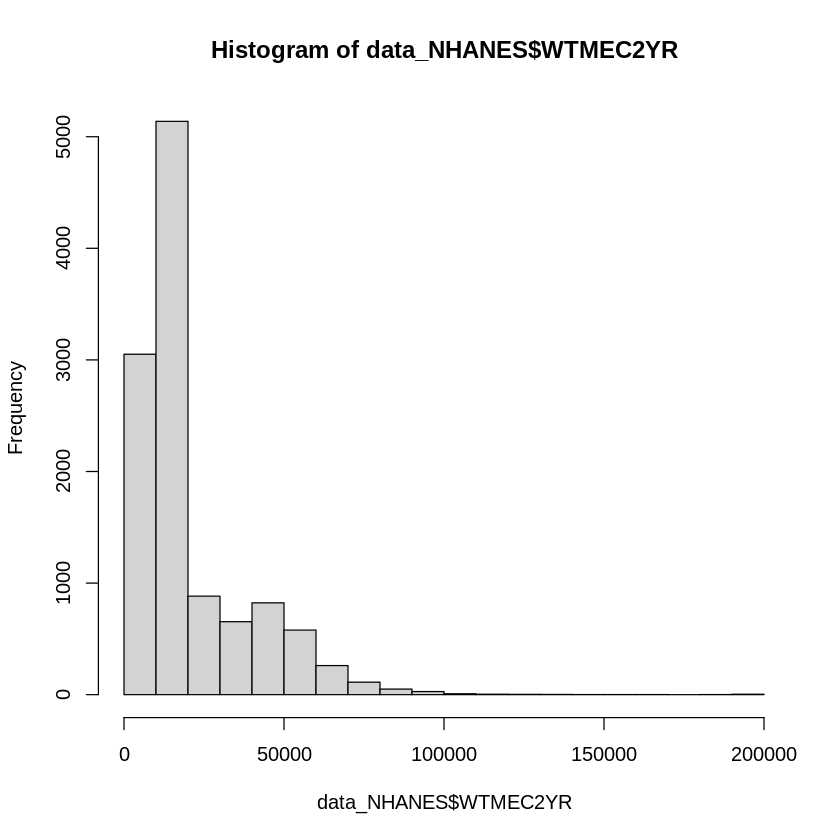

In [ ]:
hist(data_NHANES$WTMEC2YR)

# 7) Begin model-fitting

## ```survey::svydesign()```

In [ ]:
model1<- svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, data= data_NHANES, nest= TRUE)
summary(model1)

Stratified 1 - level Cluster Sampling design (with replacement)
With (271) clusters.
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)
Probabilities:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
5.089e-06 4.106e-05 7.523e-05 7.727e-05 1.015e-04 5.553e-04 
Stratum Sizes: 
            1  2  3   4  5  6  7  8  9 10 11 12 13 29  30 31 32  33  34 35  36
obs        79 72 62 103 76 86 70 63 84 75 74 73 57 81 108 65 57 123 104 75 103
design.PSU  3  2  2   2  2  2  2  2  2  2  2  2  2  2   2  2  2   2   2  2   2
actual.PSU  3  2  2   2  2  2  2  2  2  2  2  2  2  2   2  2  2   2   2  2   2
           37 38 39 40 41  42 43 44 45  46 47 48  49 50  51 52  53  54 55  56
obs        97 85 80 86 87 128 82 74 95 105 81 87 117 75 106 77 104 102 85 118
design.PSU  2  2  2  2  2   2  2  2  2   2  2  2   2  2   2  2   2   2  2   2
actual.PSU  2  2  2  2  2   2  2  2  2   2  2  2   2  2   2  2   2   2  2   2
           57 58 59 60  61  62 

In [ ]:
#unadjusted model #1- serum cotinine and asthma
unadjust<-svyglm( Asthma_bin~Cotinine_num, design = model1, family=binomial )## run model

summary(unadjust)## summary of model

exp(0.25169) #calculate Odd ratio
exp(0.25169+ 1.96 *0.07235) ## lower limit of CI
exp(0.25169- 1.96 *0.07235) ## upper limit of CI

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_num, design = model1, 
    family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.82823    0.05315 -34.400  < 2e-16 ***
Cotinine_num1  0.25169    0.07235   3.479 0.000675 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000086)

Number of Fisher Scoring iterations: 4


[1] 1.286197

[1] 1.482153

[1] 1.116149

## Analysis 1 (unadjusted)

In [ ]:
#unadjusted model #1- BMI group and asthma
unadjust<-svyglm(Asthma_bin~BMI_num, design=model1, family=binomial)
summary(unadjust)

#group1
exp(0.47602) #OR
exp(0.47602+ 1.96 *0.12126)
exp(0.47602- 1.96 *0.12126)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ BMI_num, design = model1, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.78939    0.04544 -39.379  < 2e-16 ***
BMI_num1     0.47602    0.12126   3.926 0.000137 ***
BMI_num2     0.77654    0.13728   5.657 8.74e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000086)

Number of Fisher Scoring iterations: 4


[1] 1.609655

[1] 2.04151

[1] 1.269154

In [ ]:
#group2
exp(0.77654) #OR
exp(0.77654+ 1.96 *0.13728)
exp(0.77654- 1.96 *0.13728)

#unadjusted model #1- Asthma and interaction of BMI and cotinine levels.
unadjust<-svyglm(Asthma_bin~Cotinine_group:BMI_group, design=model1, family=binomial)
summary(unadjust)

exp(unadjust$coefficients)
exp(confint(unadjust))



[1] 2.173937

[1] 2.84513

[1] 1.661085

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_group:BMI_group, design = model1, 
    family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients: (1 not defined because of singularities)
                                                Estimate Std. Error t value
(Intercept)                                     -1.92384    0.05725 -33.603
Cotinine_grouphigh:BMI_groupobese                0.95069    0.18614   5.107
Cotinine_grouplow:BMI_groupobese                 0.84245    0.19048   4.423
Cotinine_grouphigh:BMI_groupoverweight           0.62445    0.14193   4.400
Cotinine_grouplow:BMI_groupoverweight            0.59686    0.15644   3.815
Cotinine_grouphigh:BMI_groupunder/normal weight  0.26868    0.08233   3.263
                                                Pr(>|t|)    
(Intercept)                                      < 2e-16 ***
Cotinine_grouphigh:BMI_groupobese               1.11e-06 ***
Cotini

(Intercept) 
                                      0.1460452 
              Cotinine_grouphigh:BMI_groupobese 
                                      2.5874990 
               Cotinine_grouplow:BMI_groupobese 
                                      2.3220392 
         Cotinine_grouphigh:BMI_groupoverweight 
                                      1.8672258 
          Cotinine_grouplow:BMI_groupoverweight 
                                      1.8163980 
Cotinine_grouphigh:BMI_groupunder/normal weight 
                                      1.3082340 
 Cotinine_grouplow:BMI_groupunder/normal weight 
                                             NA

,2.5 %,97.5 %
(Intercept),0.130409,0.1635563
Cotinine_grouphigh:BMI_groupobese,1.790547,3.7391661
Cotinine_grouplow:BMI_groupobese,1.593105,3.3845007
Cotinine_grouphigh:BMI_groupoverweight,1.410175,2.4724113
Cotinine_grouplow:BMI_groupoverweight,1.332992,2.4751104
Cotinine_grouphigh:BMI_groupunder/normal weight,1.111639,1.5395976


## Analysis 2: adjusted FOR AGE & SEX- serum cotinine and asthma

In [ ]:
##### MODEL# 2

unadjust<-svyglm(Asthma_bin~Cotinine_num+ Gender+Age_y, design=model1, family=binomial)
summary(unadjust)

exp(unadjust$coefficients)
exp(confint(unadjust))

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_num + Gender + Age_y, 
    design = model1, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.67481    0.12020 -22.253  < 2e-16 ***
Cotinine_num1  0.27988    0.07297   3.835 0.000192 ***
GenderMale     0.39809    0.06970   5.711 6.84e-08 ***
Age_y          0.07584    0.01208   6.278 4.37e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 0.9960045)

Number of Fisher Scoring iterations: 4


(Intercept) Cotinine_num1    GenderMale         Age_y 
   0.06891975    1.32297245    1.48898226    1.07878958

,2.5 %,97.5 %
(Intercept),0.05433814,0.08741432
Cotinine_num1,1.14518316,1.52836347
GenderMale,1.29724144,1.70906364
Age_y,1.05332067,1.10487431


In [ ]:
#adjusted FOR AGE & SEX- BMI group and asthma
unadjust<-svyglm(Asthma_bin~BMI_num+ Gender+Age_y, design=model1, family=binomial)
summary(unadjust)

exp(unadjust$coefficients)
exp(confint(unadjust))

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ BMI_num + Gender + Age_y, design = model1, 
    family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.42379    0.11318 -21.416  < 2e-16 ***
BMI_num1     0.37005    0.12482   2.965  0.00359 ** 
BMI_num2     0.66969    0.13854   4.834 3.61e-06 ***
GenderMale   0.41537    0.06938   5.987 1.85e-08 ***
Age_y        0.05211    0.01204   4.327 2.93e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 0.9973801)

Number of Fisher Scoring iterations: 4


(Intercept)    BMI_num1    BMI_num2  GenderMale       Age_y 
 0.08858495  1.44780372  1.95363672  1.51492365  1.05349404

,2.5 %,97.5 %
(Intercept),0.07081827,0.1108089
BMI_num1,1.13108317,1.8532109
BMI_num2,1.48539604,2.5694807
GenderMale,1.32068410,1.7377310
Age_y,1.02869812,1.0788876


In [ ]:
#adjusted FOR AGE & SEX- Asthma and interaction of BMI and cotinine levels.
unadjust<-svyglm(Asthma_bin~Cotinine_group:BMI_group+Gender+Age_y , design=model1, family=binomial)
summary(unadjust)


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_group:BMI_group + Gender + 
    Age_y, design = model1, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients: (1 not defined because of singularities)
                                                Estimate Std. Error t value
(Intercept)                                     -2.60209    0.12265 -21.215
GenderMale                                       0.41255    0.06961   5.926
Age_y                                            0.05653    0.01214   4.656
Cotinine_grouphigh:BMI_groupobese                0.84663    0.18902   4.479
Cotinine_grouplow:BMI_groupobese                 0.72664    0.19354   3.754
Cotinine_grouphigh:BMI_groupoverweight           0.53526    0.14463   3.701
Cotinine_grouplow:BMI_groupoverweight            0.47710    0.16040   2.974
Cotinine_grouphigh:BMI_groupunder/normal weight  0.29201    0.08294   3.521
                    

In [ ]:
exp(unadjust$coefficients)
exp(confint(unadjust))


(Intercept) 
                                     0.07411819 
                                     GenderMale 
                                     1.51065902 
                                          Age_y 
                                     1.05815366 
              Cotinine_grouphigh:BMI_groupobese 
                                     2.33176765 
               Cotinine_grouplow:BMI_groupobese 
                                     2.06810983 
         Cotinine_grouphigh:BMI_groupoverweight 
                                     1.70788836 
          Cotinine_grouplow:BMI_groupoverweight 
                                     1.61140185 
Cotinine_grouphigh:BMI_groupunder/normal weight 
                                     1.33912256 
 Cotinine_grouplow:BMI_groupunder/normal weight 
                                             NA

,2.5 %,97.5 %
(Intercept),0.05814989,0.09447147
GenderMale,1.31631521,1.73369621
Age_y,1.03304352,1.08387415
Cotinine_grouphigh:BMI_groupobese,1.60432655,3.38904841
Cotinine_grouplow:BMI_groupobese,1.41025677,3.03283654
Cotinine_grouphigh:BMI_groupoverweight,1.28292085,2.27362635
Cotinine_grouplow:BMI_groupoverweight,1.17326018,2.21316293
Cotinine_grouphigh:BMI_groupunder/normal weight,1.13648403,1.57789215


## Analysis 3: adjusted FOR age, sex, ethnicity, reference person gener and marital status- serum cotinine and asthma 

In [ ]:
##### MODEL#3

#adjusted FOR age, sex, ethnicity, reference person gener and marital status- serum cotinine and asthma 
unadjust<-svyglm(Asthma_bin~Cotinine_num+ Gender+Age_y +Ethnicity+Ref_gend+Ref_marital, design=model1, family=binomial)
summary(unadjust)

exp(unadjust$coefficients)
exp(confint(unadjust))


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_num + Gender + Age_y + 
    Ethnicity + Ref_gend + Ref_marital, design = model1, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                               -2.73775    0.17832 -15.353  < 2e-16
Cotinine_num1                              0.16284    0.07895   2.063   0.0413
GenderMale                                 0.40591    0.06891   5.890 3.66e-08
Age_y                                      0.07513    0.01201   6.256 6.45e-09
EthnicityNon-Hispanic Black                0.51016    0.09098   5.607 1.36e-07
EthnicityNon-Hispanic White                0.16546    0.09785   1.691   0.0935
EthnicityOther Hispanic                    0.50007    0.11836   4.225 4.71e-05
EthnicityOther Race - Including Multi-Rac  0.24510    0.12765   1.920   0.0572
Ref_gendM

(Intercept) 
                               0.06471549 
                            Cotinine_num1 
                               1.17684352 
                               GenderMale 
                               1.50066333 
                                    Age_y 
                               1.07802288 
              EthnicityNon-Hispanic Black 
                               1.66555095 
              EthnicityNon-Hispanic White 
                               1.17993466 
                  EthnicityOther Hispanic 
                               1.64883490 
EthnicityOther Race - Including Multi-Rac 
                               1.27774777 
                             Ref_gendMale 
                               0.90793213 
                    Ref_maritalDon't know 
                               2.19990539 
                    Ref_maritalDon't Know 
                               0.59672088 
           Ref_maritalLiving with partner 
                               1.01228862 
                       Ref_maritalMarried 
                               0.88669093 
   Ref_maritalMarried/Living with partner 
                               0.88933273 
                 Ref_maritalNever married 
                               1.19435865 
                 Ref_maritalNever Married 
                               1.12611082 
                       Ref_maritalRefused 
                               1.30702699 
                     Ref_maritalSeparated 
                               0.96241841 
                       Ref_maritalWidowed 
                               1.10533670 
    Ref_maritalWidowed/Divorced/Separated 
                               1.04632464

,2.5 %,97.5 %
(Intercept),0.04546365,0.09211964
Cotinine_num1,1.00653055,1.37597481
GenderMale,1.30925829,1.72005055
Age_y,1.05268965,1.10396577
EthnicityNon-Hispanic Black,1.39097894,1.99432205
EthnicityNon-Hispanic White,0.97209857,1.43220641
EthnicityOther Hispanic,1.30434428,2.08430899
EthnicityOther Race - Including Multi-Rac,0.99236279,1.64520415
Ref_gendMale,0.77222227,1.06749155
Ref_maritalDon't know,1.03987537,4.65400361


In [ ]:
#adjusted FOR age, sex, ethnicity, reference person gener and marital status- BMI group and asthma
unadjust<-svyglm(Asthma_bin~BMI_num+ Gender+Age_y+Ethnicity+Ref_gend+Ref_marital, design=model1, family=binomial)
summary(unadjust)

exp(unadjust$coefficients)
exp(confint(unadjust))

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ BMI_num + Gender + Age_y + Ethnicity + 
    Ref_gend + Ref_marital, design = model1, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                               -2.61091    0.18158 -14.379  < 2e-16
BMI_num1                                   0.36092    0.12599   2.865  0.00494
BMI_num2                                   0.61143    0.13692   4.466 1.84e-05
GenderMale                                 0.42111    0.06878   6.122 1.25e-08
Age_y                                      0.05375    0.01214   4.428 2.14e-05
EthnicityNon-Hispanic Black                0.57757    0.08385   6.889 2.93e-10
EthnicityNon-Hispanic White                0.24382    0.09453   2.579  0.01113
EthnicityOther Hispanic                    0.52633    0.11671   4.510 1.54e-05
EthnicityOther

(Intercept) 
                               0.07346738 
                                 BMI_num1 
                               1.43465097 
                                 BMI_num2 
                               1.84306198 
                               GenderMale 
                               1.52365776 
                                    Age_y 
                               1.05522442 
              EthnicityNon-Hispanic Black 
                               1.78170527 
              EthnicityNon-Hispanic White 
                               1.27611548 
                  EthnicityOther Hispanic 
                               1.69270579 
EthnicityOther Race - Including Multi-Rac 
                               1.36008269 
                             Ref_gendMale 
                               0.91623560 
                    Ref_maritalDon't know 
                               2.07143840 
                    Ref_maritalDon't Know 
                               0.50136224 
           Ref_maritalLiving with partner 
                               1.01033318 
                       Ref_maritalMarried 
                               0.86798636 
   Ref_maritalMarried/Living with partner 
                               0.85926972 
                 Ref_maritalNever married 
                               1.22548527 
                 Ref_maritalNever Married 
                               1.10855129 
                       Ref_maritalRefused 
                               1.29304551 
                     Ref_maritalSeparated 
                               0.96089692 
                       Ref_maritalWidowed 
                               1.11241583 
    Ref_maritalWidowed/Divorced/Separated 
                               1.03870381

,2.5 %,97.5 %
(Intercept),0.05127831,0.1052581
BMI_num1,1.11788292,1.8411798
BMI_num2,1.40536138,2.4170847
GenderMale,1.32963080,1.7459982
Age_y,1.03015716,1.0809017
EthnicityNon-Hispanic Black,1.50913201,2.1035096
EthnicityNon-Hispanic White,1.05825934,1.5388201
EthnicityOther Hispanic,1.34340732,2.1328251
EthnicityOther Race - Including Multi-Rac,1.05689822,1.7502394
Ref_gendMale,0.77839418,1.0784866


In [ ]:
#adjusted FOR age, sex, ethnicity, reference person gener and marital status Asthma and interaction of BMI and cotinine levels.
unadjust<-svyglm(Asthma_bin~Cotinine_group:BMI_group+Gender+Age_y+Ethnicity+Ref_gend+Ref_marital , design=model1, family=binomial)
summary(unadjust)

exp(unadjust$coefficients)

exp(confint(unadjust))

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_group:BMI_group + Gender + 
    Age_y + Ethnicity + Ref_gend + Ref_marital, design = model1, 
    family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_NHANES, nest = TRUE)

Coefficients: (1 not defined because of singularities)
                                                 Estimate Std. Error t value
(Intercept)                                     -2.710572   0.182233 -14.874
GenderMale                                       0.418847   0.068859   6.083
Age_y                                            0.056227   0.012132   4.635
EthnicityNon-Hispanic Black                      0.540135   0.092208   5.858
EthnicityNon-Hispanic White                      0.217109   0.097474   2.227
EthnicityOther Hispanic                          0.519892   0.116797   4.451
EthnicityOther Race - Including Multi-Rac        0.292490   0.126981   2.303
Ref_gendMale                                  

(Intercept) 
                                     0.06649877 
                                     GenderMale 
                                     1.52020741 
                                          Age_y 
                                     1.05783739 
                    EthnicityNon-Hispanic Black 
                                     1.71623913 
                    EthnicityNon-Hispanic White 
                                     1.24248004 
                        EthnicityOther Hispanic 
                                     1.68184664 
      EthnicityOther Race - Including Multi-Rac 
                                     1.33975930 
                                   Ref_gendMale 
                                     0.91726291 
                          Ref_maritalDon't know 
                                     2.11460662 
                          Ref_maritalDon't Know 
                                     0.52056973 
                 Ref_maritalLiving with partner 
                                     1.00169941 
                             Ref_maritalMarried 
                                     0.89145838 
         Ref_maritalMarried/Living with partner 
                                     0.89144681 
                       Ref_maritalNever married 
                                     1.19849208 
                       Ref_maritalNever Married 
                                     1.09698262 
                             Ref_maritalRefused 
                                     1.28881080 
                           Ref_maritalSeparated 
                                     0.95206366 
                             Ref_maritalWidowed 
                                     1.09585416 
          Ref_maritalWidowed/Divorced/Separated 
                                     1.03657228 
              Cotinine_grouphigh:BMI_groupobese 
                                     2.00276815 
               Cotinine_grouplow:BMI_groupobese 
                                     2.01760244 
         Cotinine_grouphigh:BMI_groupoverweight 
                                     1.52123877 
          Cotinine_grouplow:BMI_groupoverweight 
                                     1.59876929 
Cotinine_grouphigh:BMI_groupunder/normal weight 
                                     1.19182426 
 Cotinine_grouplow:BMI_groupunder/normal weight 
                                             NA

,2.5 %,97.5 %
(Intercept),0.04634967,0.09540707
GenderMale,1.32637602,1.74236456
Age_y,1.03272029,1.08356538
EthnicityNon-Hispanic Black,1.42973443,2.06015656
EthnicityNon-Hispanic White,1.02432264,1.50710001
EthnicityOther Hispanic,1.33447716,2.11963772
EthnicityOther Race - Including Multi-Rac,1.04181602,1.72290974
Ref_gendMale,0.77938826,1.07952774
Ref_maritalDon't know,1.04247846,4.28935591
Ref_maritalDon't Know,0.05665312,4.78336976


## Analysis step 4: stratify by sex

In [ ]:
### Stratified analysis by sex- Splitting sex up to male and female

data_males<-filter(data_NHANES, Gender == "Male") #only males
data_females<-filter(data_NHANES, Gender == "Female") #only females

#adjusted FOR age, sex, ethnicity, reference person gender and marital status- serum cotinine / BMI interaction and asthma 
model2<- svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, data= data_males, nest= TRUE) #survey model for only males
model3<- svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, data= data_females, nest= TRUE) #survey model for only females

In [ ]:
#Run adjusted model for interaction term- MALES
unadjust<-svyglm(Asthma_bin~Cotinine_group:BMI_group+Age_y+Ethnicity+Ref_gend+Ref_marital , design=model2, family=binomial)
summary(unadjust)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_group:BMI_group + Age_y + 
    Ethnicity + Ref_gend + Ref_marital, design = model2, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_males, nest = TRUE)

Coefficients: (1 not defined because of singularities)
                                                Estimate Std. Error t value
(Intercept)                                     -2.18640    0.21440 -10.198
Age_y                                            0.04276    0.01630   2.623
EthnicityNon-Hispanic Black                      0.51891    0.11050   4.696
EthnicityNon-Hispanic White                      0.15742    0.11734   1.341
EthnicityOther Hispanic                          0.32619    0.16269   2.005
EthnicityOther Race - Including Multi-Rac        0.13065    0.15554   0.840
Ref_gendMale                                    -0.04054    0.10732  -0.378
Ref_maritalDon't know                            0.78526    0.39272  

In [ ]:
#get OR and 95% CI
exp(unadjust$coefficients)
exp(confint(unadjust))


(Intercept) 
                                      0.1123203 
                                          Age_y 
                                      1.0436832 
                    EthnicityNon-Hispanic Black 
                                      1.6801872 
                    EthnicityNon-Hispanic White 
                                      1.1704827 
                        EthnicityOther Hispanic 
                                      1.3856799 
      EthnicityOther Race - Including Multi-Rac 
                                      1.1395681 
                                   Ref_gendMale 
                                      0.9602696 
                          Ref_maritalDon't know 
                                      2.1929728 
                          Ref_maritalDon't Know 
                                      2.0908557 
                 Ref_maritalLiving with partner 
                                      0.9484871 
                             Ref_maritalMarried 
                                      0.9754904 
         Ref_maritalMarried/Living with partner 
                                      0.8227332 
                       Ref_maritalNever married 
                                      1.2603123 
                       Ref_maritalNever Married 
                                      1.0403387 
                             Ref_maritalRefused 
                                      1.6340318 
                           Ref_maritalSeparated 
                                      1.1490781 
                             Ref_maritalWidowed 
                                      1.5719190 
          Ref_maritalWidowed/Divorced/Separated 
                                      0.8717747 
              Cotinine_grouphigh:BMI_groupobese 
                                      2.0408021 
               Cotinine_grouplow:BMI_groupobese 
                                      2.0237078 
         Cotinine_grouphigh:BMI_groupoverweight 
                                      1.4404525 
          Cotinine_grouplow:BMI_groupoverweight 
                                      1.3891668 
Cotinine_grouphigh:BMI_groupunder/normal weight 
                                      1.1806768 
 Cotinine_grouplow:BMI_groupunder/normal weight 
                                             NA

,2.5 %,97.5 %
(Intercept),0.07345729,0.1717441
Age_y,1.01052305,1.0779314
EthnicityNon-Hispanic Black,1.34991369,2.0912662
EthnicityNon-Hispanic White,0.92774469,1.4767314
EthnicityOther Hispanic,1.00396214,1.9125311
EthnicityOther Race - Including Multi-Rac,0.83743662,1.5507029
Ref_gendMale,0.77638806,1.1877021
Ref_maritalDon't know,1.00744955,4.7735688
Ref_maritalDon't Know,0.24093893,18.1443379
Ref_maritalLiving with partner,0.62875885,1.4307993


In [ ]:

#Run adjusted model for interaction term- FEMALES
unadjust<-svyglm(Asthma_bin~Cotinine_group:BMI_group+Age_y+Ethnicity+Ref_gend+Ref_marital , design=model3, family=binomial)
summary(unadjust)
#get OR and 95% CI
exp(unadjust$coefficients)
exp(confint(unadjust))


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Asthma_bin ~ Cotinine_group:BMI_group + Age_y + 
    Ethnicity + Ref_gend + Ref_marital, design = model3, family = binomial)

Survey design:
svydesign(id = ~SDMVPSU, strata = ~SDMVSTRA, weight = ~WTMEC2YR, 
    data = data_females, nest = TRUE)

Coefficients: (1 not defined because of singularities)
                                                  Estimate Std. Error t value
(Intercept)                                      -2.918055   0.275070 -10.608
Age_y                                             0.078238   0.018374   4.258
EthnicityNon-Hispanic Black                       0.572093   0.140901   4.060
EthnicityNon-Hispanic White                       0.304467   0.145017   2.100
EthnicityOther Hispanic                           0.804247   0.171931   4.678
EthnicityOther Race - Including Multi-Rac         0.521043   0.189663   2.747
Ref_gendMale                                     -0.161500   0.129395  -1.248
Ref_maritalDon't Know                           -12

(Intercept) 
                                   5.403871e-02 
                                          Age_y 
                                   1.081380e+00 
                    EthnicityNon-Hispanic Black 
                                   1.771973e+00 
                    EthnicityNon-Hispanic White 
                                   1.355902e+00 
                        EthnicityOther Hispanic 
                                   2.235013e+00 
      EthnicityOther Race - Including Multi-Rac 
                                   1.683783e+00 
                                   Ref_gendMale 
                                   8.508666e-01 
                          Ref_maritalDon't Know 
                                   6.039164e-06 
                 Ref_maritalLiving with partner 
                                   1.091858e+00 
                             Ref_maritalMarried 
                                   8.003240e-01 
         Ref_maritalMarried/Living with partner 
                                   1.002785e+00 
                       Ref_maritalNever married 
                                   1.140846e+00 
                       Ref_maritalNever Married 
                                   1.185505e+00 
                             Ref_maritalRefused 
                                   9.327697e-01 
                           Ref_maritalSeparated 
                                   7.343013e-01 
                             Ref_maritalWidowed 
                                   6.555018e-01 
          Ref_maritalWidowed/Divorced/Separated 
                                   1.285227e+00 
              Cotinine_grouphigh:BMI_groupobese 
                                   2.029169e+00 
               Cotinine_grouplow:BMI_groupobese 
                                   1.984018e+00 
         Cotinine_grouphigh:BMI_groupoverweight 
                                   1.662863e+00 
          Cotinine_grouplow:BMI_groupoverweight 
                                   1.866550e+00 
Cotinine_grouphigh:BMI_groupunder/normal weight 
                                   1.221492e+00 
 Cotinine_grouplow:BMI_groupunder/normal weight 
                                             NA

,2.5 %,97.5 %
(Intercept),3.134134e-02,9.317349e-02
Age_y,1.042737e+00,1.121455e+00
EthnicityNon-Hispanic Black,1.340506e+00,2.342315e+00
EthnicityNon-Hispanic White,1.017419e+00,1.806994e+00
EthnicityOther Hispanic,1.590020e+00,3.141648e+00
EthnicityOther Race - Including Multi-Rac,1.156531e+00,2.451405e+00
Ref_gendMale,6.585198e-01,1.099396e+00
Ref_maritalDon't Know,1.330652e-06,2.740873e-05
Ref_maritalLiving with partner,6.477059e-01,1.840578e+00
Ref_maritalMarried,5.343136e-01,1.198769e+00
